Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [20]:
#conda update tensorflow

In [3]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("./Train")
data_dir_test = pathlib.Path('./Test')

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

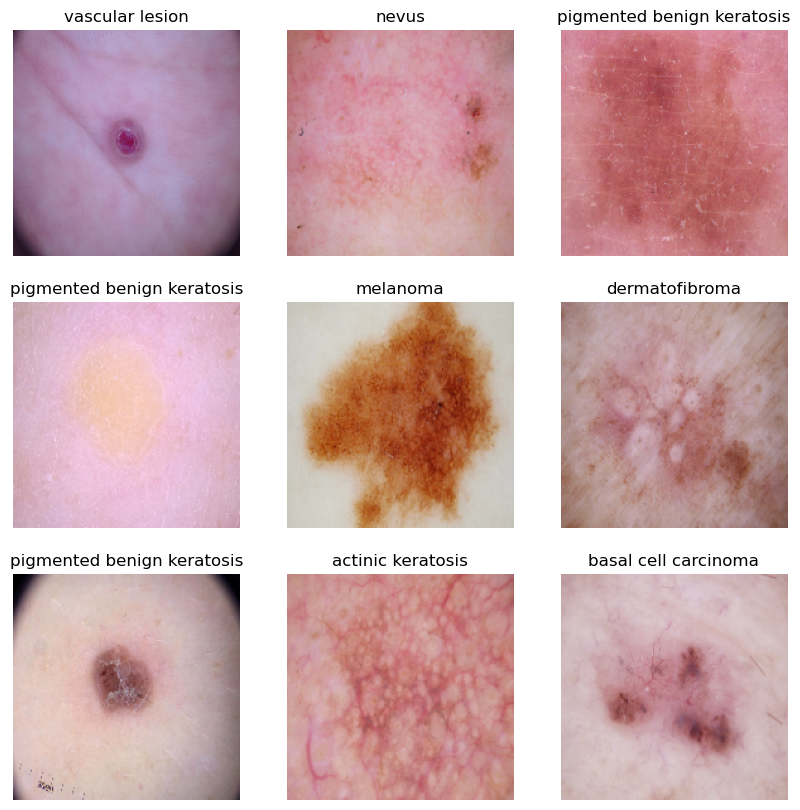

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
### your code goes here, you can use training or validation data to visualize

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
### Your code goes here
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Conv layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Flatten layer
model.add(layers.Flatten())
#Dense layer 1
model.add(layers.Dense(128,activation='relu'))
#Final layer
model.add(layers.Dense(len(class_names), activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [14]:
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 64)        1

### Train the model

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 32s 431ms/step - loss: 1.9309 - accuracy: 0.2902 - val_loss: 1.7856 - val_accuracy: 0.3400
Epoch 2/20
56/56 [==============================] - 21s 373ms/step - loss: 1.6357 - accuracy: 0.4118 - val_loss: 1.8852 - val_accuracy: 0.2953
Epoch 3/20
56/56 [==============================] - 21s 369ms/step - loss: 1.5563 - accuracy: 0.4414 - val_loss: 1.4759 - val_accuracy: 0.4922
Epoch 4/20
56/56 [==============================] - 20s 357ms/step - loss: 1.4219 - accuracy: 0.4950 - val_loss: 1.3963 - val_accuracy: 0.5123
Epoch 5/20
56/56 [==============================] - 20s 356ms/step - loss: 1.3335 - accuracy: 0.5363 - val_loss: 1.4956 - val_accuracy: 0.4519
Epoch 6/20
56/56 [==============================] - 20s 355ms/step - loss: 1.2915 - accuracy: 0.5368 - val_loss: 1.3172 - val_accuracy: 0.5459
Epoch 7/20
56/56 [==============================] - 19s 343ms/step - loss: 1.1734 - accuracy: 0.5887 - val_loss: 1.3773 - val_accuracy: 0.5101

### Visualizing training results

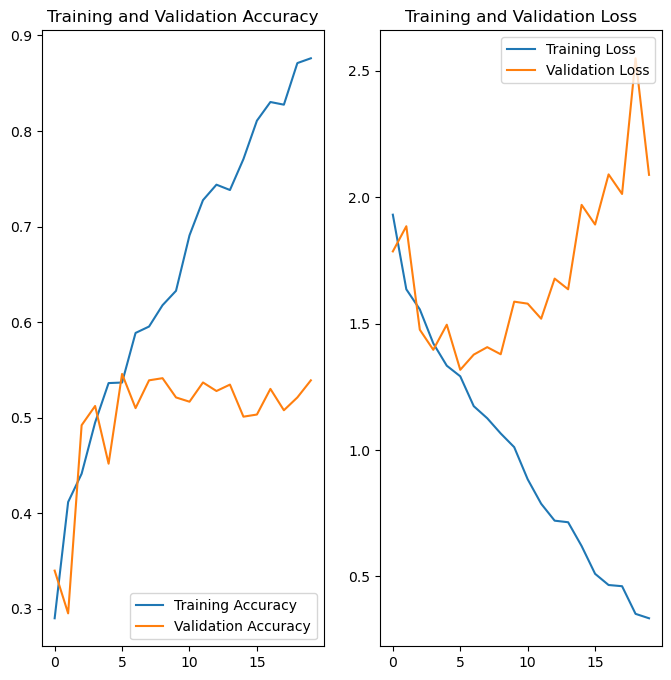

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

### There is a clear sign of overfitting here. As we can see the training accuracy is going up however there is a wide gap between training accuracy and validation accuracy. That is there is high training accuracy but low validation accuracy. We need to use batch normalization as well as drop out layer to reduce overfitting.

In [18]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(.5, .2)
])

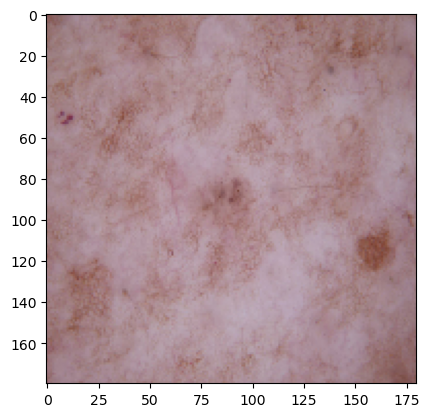

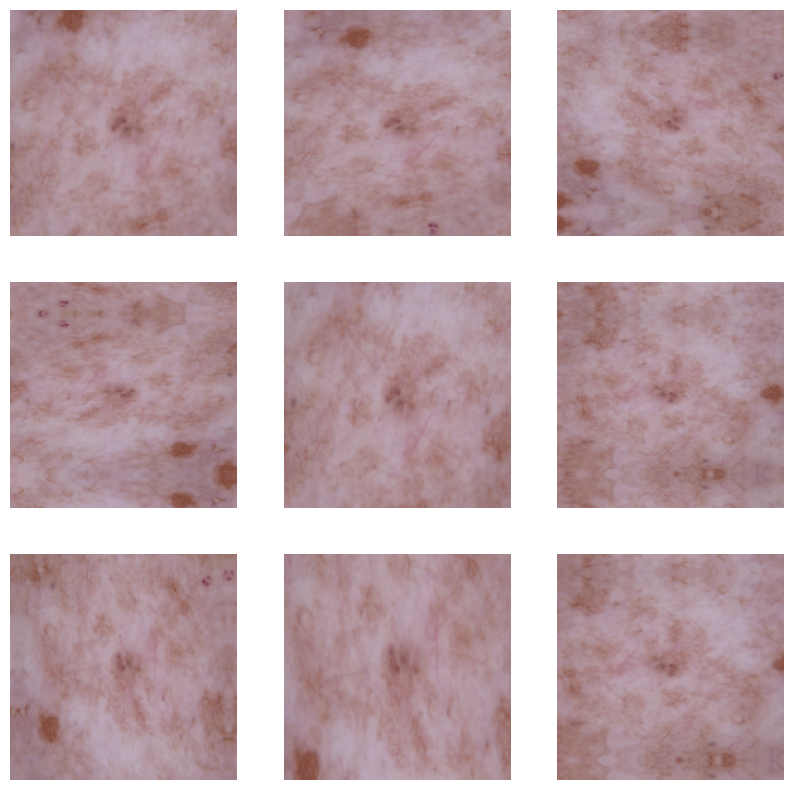

In [32]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

from glob import glob
from tensorflow.keras.preprocessing.image import load_img
Train_image_path = os.path.join(data_dir_train, class_names[1], '*')
Train_image = glob(Train_image_path)
Train_image = load_img(Train_image[-1],target_size=(180,180,3))
plt.imshow(Train_image)
plt.grid(False)

img = np.expand_dims(Train_image,axis=0)

plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(img)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [33]:
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))
model.add(layers.RandomFlip("horizontal_and_vertical"))
model.add(layers.RandomRotation(0.2))
model.add(layers.RandomZoom(.5, .2))

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Conv layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Dropout(0.15))

#Third Convulation layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Dropout(0.15))

#Flatten layer
model.add(layers.Flatten())
#Dense layer 1
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.25))
#Final layer
model.add(layers.Dense(len(class_names), activation='softmax'))

### Compiling the model

In [34]:
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 180, 180, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 180, 180, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                  

### Training the model

In [35]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 27s 447ms/step - loss: 2.1513 - accuracy: 0.1975 - val_loss: 2.0014 - val_accuracy: 0.3400
Epoch 2/20
56/56 [==============================] - 24s 429ms/step - loss: 1.8484 - accuracy: 0.3365 - val_loss: 1.7671 - val_accuracy: 0.3758
Epoch 3/20
56/56 [==============================] - 24s 434ms/step - loss: 1.7131 - accuracy: 0.3811 - val_loss: 1.6133 - val_accuracy: 0.4385
Epoch 4/20
56/56 [==============================] - 25s 439ms/step - loss: 1.6959 - accuracy: 0.3917 - val_loss: 1.6186 - val_accuracy: 0.4586
Epoch 5/20
56/56 [==============================] - 24s 433ms/step - loss: 1.6356 - accuracy: 0.3984 - val_loss: 1.5333 - val_accuracy: 0.4765
Epoch 6/20
56/56 [==============================] - 24s 430ms/step - loss: 1.6027 - accuracy: 0.4174 - val_loss: 1.5257 - val_accuracy: 0.4743
Epoch 7/20
56/56 [==============================] - 25s 443ms/step - loss: 1.5648 - accuracy: 0.4436 - val_loss: 1.4687 - val_accuracy: 0.4899

### Visualizing the results

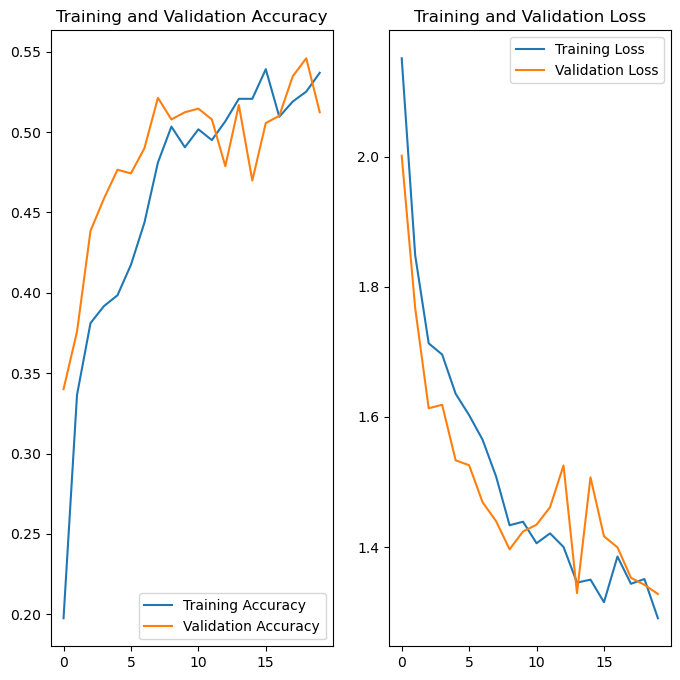

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

# Answer:
### Adding image augmenation has reduced the overfitting to a large extent, however the model is now underfitting the data. It might be due to lack of sufficient data available, we can use image augmentor to add more images to the data set. Also I will be removing the augmentation layers(as they can be computationally expensive) in the final model as we will be having sufficient data to train our model(Adding more data prevents the model from learning a small number of training samples as it is and instead it helps the model extract more general features). And also will be increasing dropout percentage after the max pooling layer to counteract overfitting in the final model.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [40]:
#count number of image in each classes
count= []
directory = data_dir_train
for path in pathlib.Path(directory).iterdir():
    if path.is_dir():
        count.append(len([name for name in os.listdir(path) 
                      if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
sub_directory = [name for name in os.listdir(directory)
                if os.path.isdir(os.path.join(directory, name))]
    
#return dataframe with image count and class.
df = pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])
print(df)

                        Class  No. of Image
0           actinic keratosis           114
1        basal cell carcinoma           376
2              dermatofibroma            95
3                    melanoma           438
4                       nevus           357
5  pigmented benign keratosis           462
6        seborrheic keratosis            77
7     squamous cell carcinoma           181
8             vascular lesion           139


<AxesSubplot: xlabel='No. of Image', ylabel='Class'>

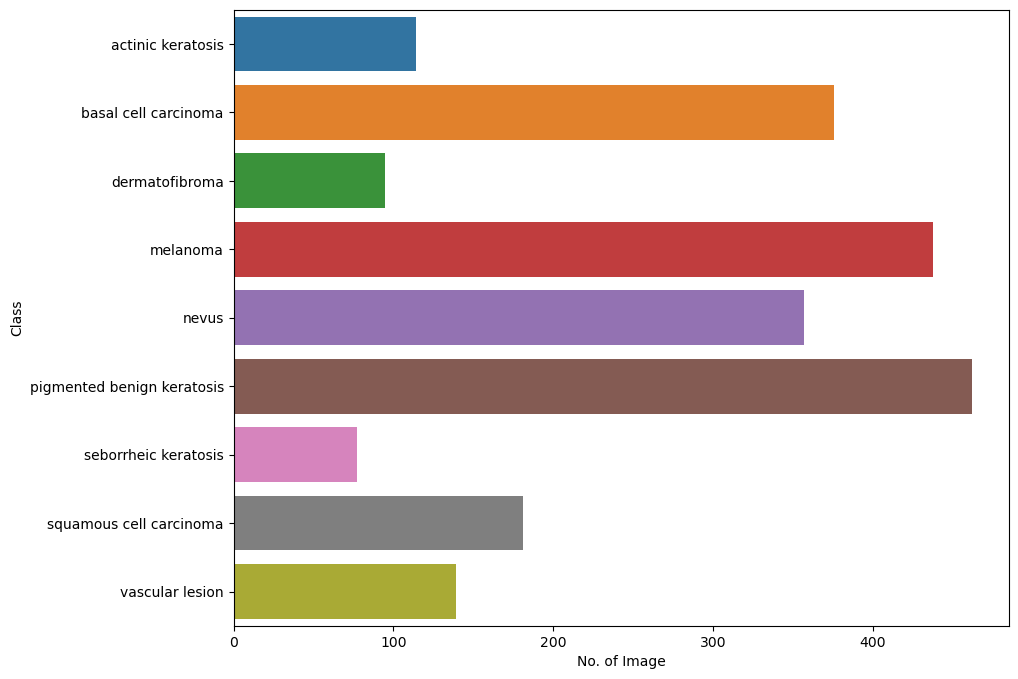

In [41]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


### Answer: seborrheic keratosis has least number of samples
### Answer: pigmented benign keratosis dominates the data in terms of maximum number of samples.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [42]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [44]:
path_to_training_dataset="./Train-Aug/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to ./Train-Aug/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16249B93C10>: 100%|█| 500/500 [00:06<00:00, 81.09 Samples/


Initialised with 376 image(s) found.
Output directory set to ./Train-Aug/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16249B85070>: 100%|█| 500/500 [00:06<00:00, 79.60 Samples/


Initialised with 95 image(s) found.
Output directory set to ./Train-Aug/dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1624B07D6D0>: 100%|█| 500/500 [00:06<00:


Initialised with 438 image(s) found.
Output directory set to ./Train-Aug/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=824x719 at 0x1624AF7B190>: 100%|█| 500/500 [00:28<00:00, 17.65 Samples/


Initialised with 357 image(s) found.
Output directory set to ./Train-Aug/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1624B07B490>: 100%|█| 500/500 [00:25<00:00, 19.94 Samples/


Initialised with 462 image(s) found.
Output directory set to ./Train-Aug/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1624A453460>: 100%|█| 500/500 [00:06<00:00, 77.99 Samples/


Initialised with 77 image(s) found.
Output directory set to ./Train-Aug/seborrheic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x162463A3730>: 100%|█| 500/500 [00:14<00


Initialised with 181 image(s) found.
Output directory set to ./Train-Aug/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x161EC1A9DF0>: 100%|█| 500/500 [00:06<00:00, 77.78 Samples/


Initialised with 139 image(s) found.
Output directory set to ./Train-Aug/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16246424190>: 100%|█| 500/500 [00:06<00:00, 74.05 Samples/


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [49]:
data_dir_train1 = pathlib.Path('./Train-Aug')
image_count_train = len(list(data_dir_train1.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [51]:
path_list = [x for x in glob(os.path.join(data_dir_train1, '*','output', '*.jpg'))]
path_list

['Train-Aug\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_22234149-a5f9-4381-a320-0cdda167a365.jpg',
 'Train-Aug\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_57722164-34d9-414e-928c-8a30d2455bae.jpg',
 'Train-Aug\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_92cda56c-2539-46b0-8e60-173ea0444424.jpg',
 'Train-Aug\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_a74df3e9-228a-48d0-8c20-af7d25af8b2c.jpg',
 'Train-Aug\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_c220ad13-fb92-4fe7-9f61-3774ce217479.jpg',
 'Train-Aug\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_1e433276-13c1-43ef-883f-84079c949b4a.jpg',
 'Train-Aug\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_20c9ec87-f776-4836-8f24-a5e97ac500cc.jpg',
 'Train-Aug\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_5c9673b5-2877-4f71-aa93-e76

In [52]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train1, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [54]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [55]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [56]:
new_df['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [57]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [59]:
data_dir_train="./Train-Aug/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [60]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [71]:
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Conv layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Dropout(0.25))

#Third Convulation layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Dropout(0.25))

#Flatten layer
model.add(layers.Flatten())
#Dense layer 1
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.25))
#Final layer
model.add(layers.Dense(len(class_names), activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [72]:
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 43, 43, 32)       0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 43, 43, 32)       

#### **Todo:**  Train your model

In [73]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 59s 347ms/step - loss: 2.1015 - accuracy: 0.1864 - val_loss: 1.9886 - val_accuracy: 0.2480
Epoch 2/30
169/169 [==============================] - 61s 357ms/step - loss: 1.7291 - accuracy: 0.3323 - val_loss: 1.4959 - val_accuracy: 0.4246
Epoch 3/30
169/169 [==============================] - 60s 353ms/step - loss: 1.5237 - accuracy: 0.4165 - val_loss: 1.4919 - val_accuracy: 0.4380
Epoch 4/30
169/169 [==============================] - 61s 361ms/step - loss: 1.4224 - accuracy: 0.4564 - val_loss: 1.3152 - val_accuracy: 0.5011
Epoch 5/30
169/169 [==============================] - 61s 361ms/step - loss: 1.3471 - accuracy: 0.4833 - val_loss: 1.2484 - val_accuracy: 0.5501
Epoch 6/30
169/169 [==============================] - 69s 407ms/step - loss: 1.2751 - accuracy: 0.5063 - val_loss: 1.2292 - val_accuracy: 0.5479
Epoch 7/30
169/169 [==============================] - 64s 377ms/step - loss: 1.2214 - accuracy: 0.5308 - val_loss: 1.3094 - val_ac

#### **Todo:**  Visualize the model results

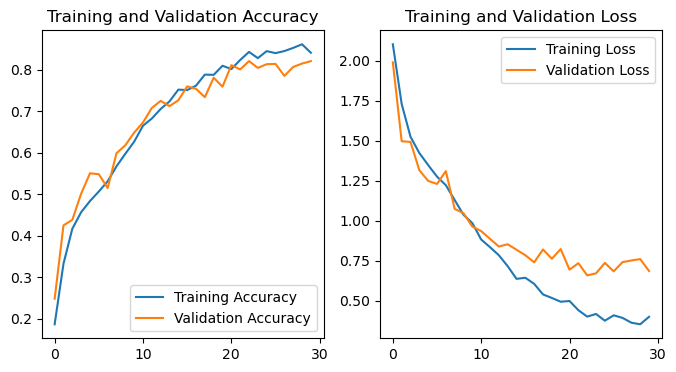

In [74]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



### This is much better than the first model where the difference between training and validation accuracy was quite huge. And also it is better than the second model which was underfitting the data. Underfitting and overfitting has been reduced to a great extent in this model so we can proceed with this model for our analysis.